In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal

# Part a

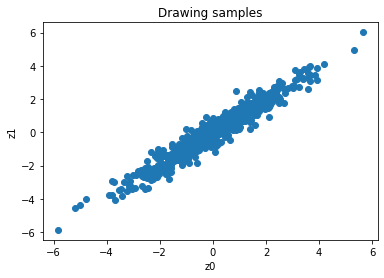

In [2]:
mu = np.zeros(2)
covariance = np.array([[3, 2.9], [2.9, 3]])
true_dist = multivariate_normal(mean=mu, cov=covariance).rvs(500)
plt.scatter(true_dist[:, 0], true_dist[:, 1])
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("Drawing samples")
plt.show()

# Part b

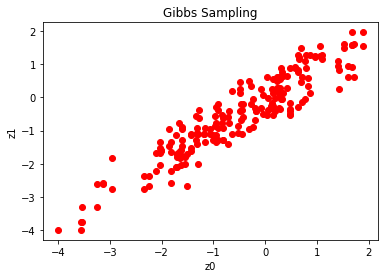

In [3]:
n = 2
n_iter = 100
# Initialise x
z = np.array([-4, -4], dtype=np.float64)
accepted = np.array(z)[np.newaxis,:]
for i in range(n_iter):
    for j in range(n):
        k = (j+1)%2
        mu_j = mu[j] + covariance[j][k]*(z[k] - mu[k])/covariance[k][k]
        var_j = covariance[j][j] - covariance[j][k]*covariance[k][j]/covariance[k][k]
        z[j] = norm(loc = mu_j, scale=np.sqrt(var_j)).rvs(1)
        accepted = np.vstack((accepted, z))
        

plt.plot(accepted[:, 0], accepted[:, 1], 'ro')
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("Gibbs Sampling")
plt.show()

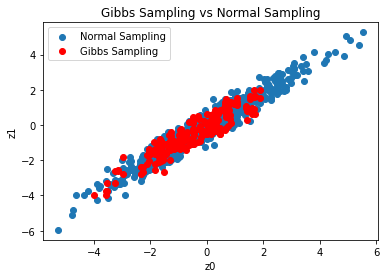

In [4]:
true_dist = multivariate_normal(mean=mu, cov=covariance).rvs(500)
plt.scatter(true_dist[:, 0], true_dist[:, 1], label="Normal Sampling")
plt.plot(accepted[:, 0], accepted[:, 1], 'ro', label="Gibbs Sampling")
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("Gibbs Sampling vs Normal Sampling")
plt.legend()
plt.show()

# Part c

In [14]:
def dU_dz(mu, cov, z):
    z = np.array(z-mu)
    grad = np.matmul(np.linalg.inv(cov),z)
    return grad

def leapfrog(z, r, s, mu, cov, eps, L):

    for i in range(L):
        r -= (eps/2)*dU_dz(mu, cov, np.copy(z))
        z += eps*np.matmul(np.linalg.inv(s), r)
        r -= (eps/2)*dU_dz(mu, cov, np.copy(z))
    return (z, r)

def accept_prob(pos_dist, current_state, next_state, mu, cov, s):
    current_state_p = pos_dist(current_state, mu, cov, s)
    next_state_p = pos_dist(next_state, mu, cov, s)
    return(np.min([1, next_state_p/current_state_p]))

def total_energy(state, mu, cov, s):
    z = state[0]
    r = np.array(state[1])
    z = np.array(z-mu)
    u = 0.5*(np.matmul(np.matmul(z.transpose(),np.linalg.inv(cov)), z))
    k = 0.5*(np.matmul(np.matmul(r.transpose(),np.linalg.inv(s)), r))
    return(np.exp(-u-k))

def hybrid_monte_carlo(mu, cov, burn_in, n_iter, eps, L, z):
    s = np.eye(2)
    r = multivariate_normal(mean=np.zeros(2), cov=s)
    mu = mu[:,np.newaxis]
    z_p = z[:,np.newaxis]
    rejected = np.array(z_p)
    accepted = np.array(z_p)
    for i in range(1, burn_in + 1):
        r_p = r.rvs(1)[:, np.newaxis]  # sampling r from normal distribution
        z_n, r_n = leapfrog(np.copy(z_p), np.copy(r_p), s, mu, cov, eps, L)
        r_n *= (-1)
        prob = accept_prob(total_energy, [z_p, r_p], [z_n, r_n], mu, cov, s)
        u = np.random.uniform(0, 1, 1)
        if (u <= prob):
            z_p = z_n

    for i in range(1, n_iter + 1):
        accept = False
        r_p = r.rvs(1)[:, np.newaxis]  # sampling r from normal distribution
        z_n, r_n = leapfrog(np.copy(z_p), np.copy(r_p), s, mu, cov, eps, L)
        r_n *= (-1)
        prob = accept_prob(total_energy, [z_p, r_p, s], [z_n, r_n, s], mu, cov, s)
        u = np.random.uniform(0, 1, 1)
        if (u <= prob):
            accept = True
        if (i % m == 0):
            if (accept):
                accepted = np.hstack((accepted, z_n))
            else:
                accepted = np.hstack((accepted, z_p))
                rejected = np.hstack((rejected, z_n))
        if (accept):
            z_p = z_n
    return accepted.transpose() #, rejected.transpose()

eps = 0.1; L = 20; m = 1
burn_in = 100000
accepted_monte = hybrid_monte_carlo(mu, covariance, burn_in, 100, eps, L, z)

/home/rvn/envs/ml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


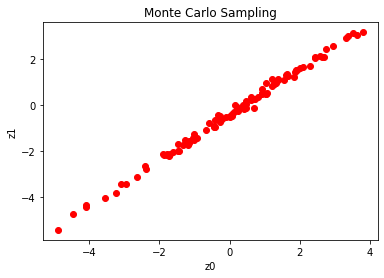

In [15]:
plt.plot(accepted_monte[:, 0], accepted_monte[:, 1], 'ro')
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("Monte Carlo Sampling")
plt.show()

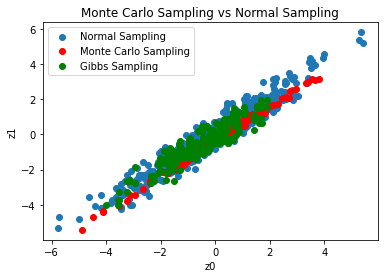

In [16]:
true_dist = multivariate_normal(mean=mu, cov=covariance).rvs(500)
plt.scatter(true_dist[:, 0], true_dist[:, 1], label="Normal Sampling")
plt.plot(accepted_monte[:, 0], accepted_monte[:, 1], 'ro', label="Monte Carlo Sampling")
plt.plot(accepted[:, 0], accepted[:, 1], 'go', label="Gibbs Sampling")
plt.xlabel("z0")
plt.ylabel("z1")
plt.title("Monte Carlo Sampling vs Normal Sampling")
plt.legend()
plt.show()